In [415]:
import pandas as pd
import os
import os.path, sys
import shutil
import glob
import numpy as np
import SimpleITK as sitk

# to plot
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

# for triangulations and mask manipulations
import numpy.ma as ma
from skimage.measure import find_contours, approximate_polygon
from scipy.spatial import Delaunay
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set(color_codes=True)

# to save graphs
import six.moves.cPickle as pickle
import gzip
import networkx as nx


# Explore graph Patterns of Malignant v.s Benign v.s Normal

In [416]:
processed_path = 'Y:\\Hongbo\\processed_data'
gt_path = 'Y:\\Hongbo\\gt_data'
graphs_path = 'Z:\\Cristina\\Section3\\breast_MR_pipeline\\graphs'

## Take graphs different lesions for exploration
## load DEL = Delaunay traingulation/Voronoi Digram = VD
amalignant_lesion='1_0002_6745896_right_FacesTriang_lesion_nxgraph.pklz' ## IN-SITU DUCT CARCINOMA
abenign_lesion='100_0536_7786869_right_FacesTriang_lesion_nxgraph.pklz' ## FIBROADENOMA
anormal_lesion='n1_0001_7575429_right_FacesTriang_allSlices_nxgraph.pklz'

# LOAD graph
print "load amalignant_DEL... %s" % amalignant_lesion

with gzip.open(os.path.join(graphs_path,amalignant_lesion), 'rb') as f:
    amalignant_DEL = pickle.load(f)
    
print "load abenign_DEL... %s" % abenign_lesion

with gzip.open(os.path.join(graphs_path,abenign_lesion), 'rb') as f:
    abenign_DEL = pickle.load(f)
    
print "load anormal_DEL_list... %s" % anormal_lesion

with gzip.open(os.path.join(graphs_path,anormal_lesion), 'rb') as f:
    anormal_DEL_list = pickle.load(f)
    
print "number of slices with detections on normal case = %d" % len(anormal_DEL_list)

# select a slice, based on exploringSER_normal_patternSampling.ipynb
anormal_DEL = anormal_DEL_list[29]
print "number of detections on slice# %d = %d" % (29, len(anormal_DEL))

anormal_DEL = anormal_DEL[4]

load amalignant_DEL... 1_0002_6745896_right_FacesTriang_lesion_nxgraph.pklz
load abenign_DEL... 100_0536_7786869_right_FacesTriang_lesion_nxgraph.pklz
load anormal_DEL_list... n1_0001_7575429_right_FacesTriang_allSlices_nxgraph.pklz
number of slices with detections on normal case = 48
number of detections on slice# 29 = 5


In [417]:
## load MST = Minimum spanning trees
amalignant_lesion='1_0002_6745896_right_MST_lesion_nxgraph.pklz' ## IN-SITU DUCT CARCINOMA
abenign_lesion='100_0536_7786869_right_MST_lesion_nxgraph.pklz' ## FIBROADENOMA
anormal='n1_0001_7575429_right_MST_allSlices_nxgraph.pklz'

print "\nload amalignant_MST... %s" % amalignant_lesion

# LOAD graph
with gzip.open(os.path.join(graphs_path, amalignant_lesion), 'rb') as f:
    amalignant_MST = pickle.load(f)
    
print "load abenign_MST... %s" % abenign_lesion

with gzip.open(os.path.join(graphs_path,abenign_lesion), 'rb') as f:
    abenign_MST = pickle.load(f)
    
print "load anormal_MST_list... %s" % anormal

with gzip.open(os.path.join(graphs_path, anormal), 'rb') as f:
    anormal_MST_list = pickle.load(f)
    
print "number of slices with detections on normal case = %d" % len(anormal_MST_list)
anormal_MST = anormal_MST_list[29]
print "number of detections on slice# %d = %d" % (29, len(anormal_MST))
    
# since for normals we have to list of graphs per slice, pick one (at random)
anormal_MST = anormal_MST[4]


load amalignant_MST... 1_0002_6745896_right_MST_lesion_nxgraph.pklz
load abenign_MST... 100_0536_7786869_right_MST_lesion_nxgraph.pklz
load anormal_MST_list... n1_0001_7575429_right_MST_allSlices_nxgraph.pklz
number of slices with detections on normal case = 48
number of detections on slice# 29 = 5


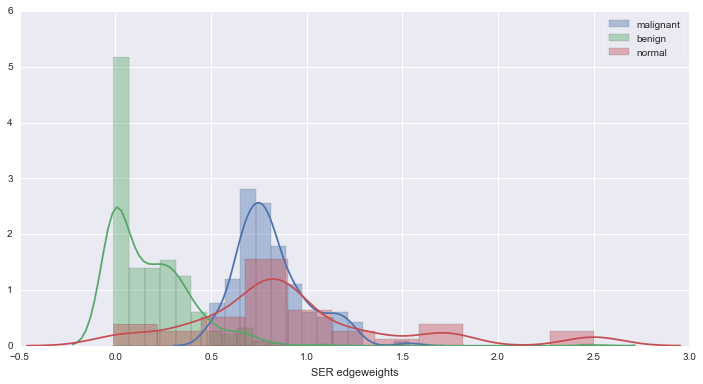

In [418]:
# Examine SER distributions acording to lesion type
# For now, using undirected graphs with node weigths corresponding to SER values 
# at node linkages (pixel locations)
#
# in this case, iterate through all edge weigths (SER values in lesion) and summarize in histogram
amalignant_SER_edgew = [d['weight'] for (u,v,d) in amalignant_MST.edges(data=True)]
abenign_SER_edgew = [d['weight'] for (u,v,d) in abenign_MST.edges(data=True)]
anormal_SER_edgew = [d['weight'] for (u,v,d) in anormal_MST.edges(data=True)]

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_SER_edgew = pd.Series(amalignant_SER_edgew, name="SER edgeweights")
ax = sns.distplot(pd_amalignant_SER_edgew, label="malignant")
# e.g 
#print(pd_amalignant_SER_edgew)

pd_amalignant_SER_edgew = pd.Series(abenign_SER_edgew, name="SER edgeweights")
ax = sns.distplot(pd_amalignant_SER_edgew, label="benign")

pd_anormal_SER_edgew = pd.Series(anormal_SER_edgew, name="SER edgeweights")
ax = sns.distplot(pd_anormal_SER_edgew, label="normal")
plt.legend()

# Analyzing graphs:

## Distance Measures (helpul for normalization)
Graph diameter, radius, eccentricity and other properties.

##### Return type:	list nodes =  center(G, e=None)
The center is the set of nodes with eccentricity equal to radius.

##### Return type:	integer =  diameter(G, e=None)
The diameter is the maximum eccentricity.

##### Return type: dictionary of eccentricity values keyed by node = eccentricity(G, v=None, sp=None)
[https://networkx.readthedocs.io/en/stable/reference/algorithms.distance_measures.html]

The eccentricity of a node v is the maximum distance from v to all other nodes in G.

##### Return type: list nodes  = periphery(G, e=None)
The periphery is the set of nodes with eccentricity equal to the diameter.

##### Return type:	integer  = radius(G, e=None)
The radius is the minimum eccentricity.

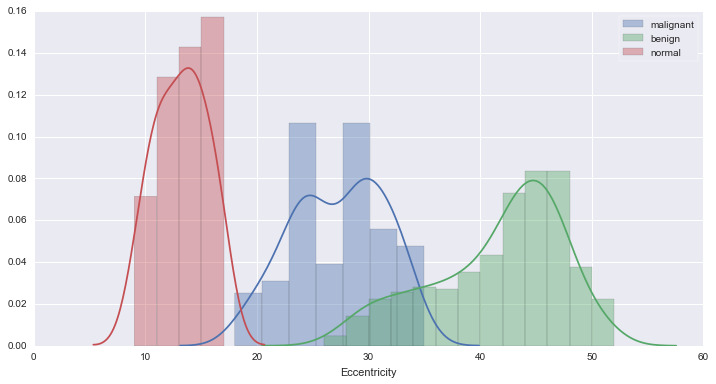

In [419]:
amalignant_ecc = nx.eccentricity(amalignant_MST)
abenign_ecc = nx.eccentricity(abenign_MST)
anormal_ecc = nx.eccentricity(anormal_MST)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_ecc = pd.Series(amalignant_ecc, name="Eccentricity")
ax = sns.distplot(pd_amalignant_ecc, label="malignant")
# e.g
#print(pd_amalignant_ecc)

pd_abenign_ecc = pd.Series(abenign_ecc, name="Eccentricity")
ax = sns.distplot(pd_abenign_ecc, label="benign")

pd_anormal_ecc = pd.Series(anormal_ecc, name="Eccentricity")
ax = sns.distplot(pd_anormal_ecc, label="normal")
plt.legend()


In [420]:
print nx.is_eulerian(amalignant_MST)
print nx.is_eulerian(abenign_MST)
print nx.is_eulerian(anormal_MST)

False
False
False


# min_edge_dominating_set

min_edge_dominating_set(G)[https://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.approximation.dominating_set.min_edge_dominating_set.html]
Return minimum cardinality edge dominating set.

Parameters:	G (NetworkX graph) – Undirected graph
Returns:	min_edge_dominating_set – Returns a set of dominating edges whose size is no more than 2 * OPT.

Return type:	set
Notes

min_weight_dominating_set – A set of nodes, the sum of whose weights is no more than (\log
w(V)) w(V^*), where w(V) denotes the sum of the weights of each node in the graph and w(V^*) denotes the sum of the weights of each node in the minimum weight dominating set.

set([(76, 91), (1, 24), (42, 44), (16, 97), (75, 88), (35, 146), (30, 31), (69, 118), (112, 115), (22, 64), (59, 60), (78, 124), (5, 74), (13, 120), (133, 140), (2, 52), (100, 144), (8, 41), (10, 53), (12, 17), (20, 70), (11, 56), (86, 92), (39, 40), (6, 80), (28, 101), (9, 32), (43, 107), (87, 113), (37, 38), (93, 137), (14, 57), (21, 61), (142, 143), (127, 130), (33, 96), (94, 99), (48, 49), (51, 114), (26, 27), (34, 105), (25, 68), (18, 98), (45, 46), (19, 71), (7, 83), (47, 110), (85, 129), (0, 126), (3, 4), (54, 128), (15, 58)])
Original malignant MST graph has 146 nodes
min edge dominating set has 52 nodes
set([(142, 145), (321, 323), (86, 87), (93, 158), (390, 412), (44, 70), (253, 416), (40, 41), (392, 403), (385, 387), (127, 128), (113, 114), (57, 144), (262, 263), (172, 173), (43, 300), (83, 133), (244, 311), (119, 204), (264, 340), (84, 131), (169, 170), (243, 329), (267, 334), (10, 160), (55, 56), (289, 290), (319, 326), (31, 200), (365, 366), (103, 104), (146, 164), (258, 

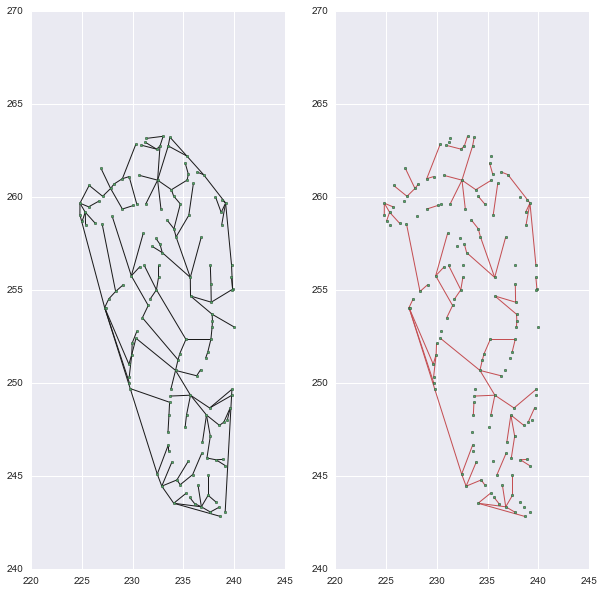

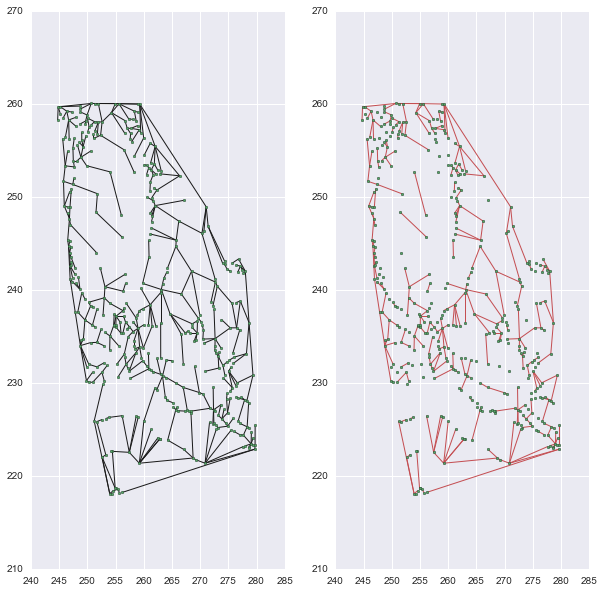

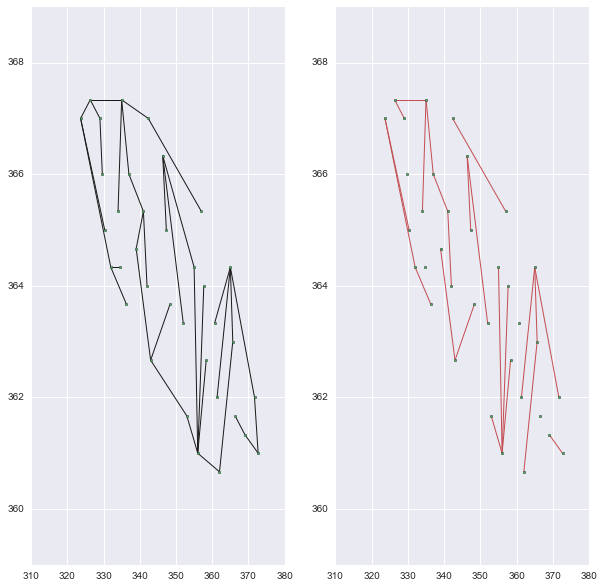

In [421]:
from networkx.algorithms import approximation as apxa
amalignant_min_edgeSet = apxa.min_edge_dominating_set(amalignant_MST)
print amalignant_min_edgeSet    
  
print "Original malignant MST graph has %d nodes" %amalignant_MST.number_of_edges()
print "min edge dominating set has %d nodes" % len(apxa.min_edge_dominating_set(amalignant_MST))

abenign_min_edgeSet = apxa.min_edge_dominating_set(abenign_MST)
print abenign_min_edgeSet    
print "Original benign MST graph has %d nodes" % abenign_MST.number_of_edges()
print "min edge dominating set has %d nodes" % len(apxa.min_edge_dominating_set(abenign_MST))

anormal_min_edgeSet = apxa.min_edge_dominating_set(anormal_MST)
print anormal_min_edgeSet  
print "Original normal MST graph has %d nodes" %anormal_MST.number_of_edges()
print "min edge dominating set has %d nodes" % len(apxa.min_edge_dominating_set(anormal_MST))

# draw
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
pos = [p['pos'] for (v,p) in amalignant_MST.nodes(data=True)]
nx.draw_networkx(amalignant_MST, pos, ax=ax[0], node_size=30, node_shape='.', node_color='g', with_labels=False)
# remove edges from original  
amalignant_MSTcopy = amalignant_MST.copy()
amalignant_MSTcopy.remove_edges_from(amalignant_min_edgeSet)        
pos = [p['pos'] for (v,p) in amalignant_MSTcopy.nodes(data=True)]
nx.draw_networkx(amalignant_MSTcopy, pos, ax=ax[1], node_size=30, node_shape='.', node_color='g', edge_color='r', with_labels=False)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
pos = [p['pos'] for (v,p) in abenign_MST.nodes(data=True)]
nx.draw_networkx(abenign_MST, pos, ax=ax[0], node_size=30, node_shape='.', node_color='g', with_labels=False)
# remove edges from original  
abenign_MSTcopy = abenign_MST.copy()
abenign_MSTcopy.remove_edges_from(abenign_min_edgeSet)        
pos = [p['pos'] for (v,p) in abenign_MSTcopy.nodes(data=True)]
nx.draw_networkx(abenign_MSTcopy, pos, ax=ax[1], node_size=30, node_shape='.', node_color='g', edge_color='r', with_labels=False)


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
pos = [p['pos'] for (v,p) in anormal_MST.nodes(data=True)]
nx.draw_networkx(anormal_MST, pos, ax=ax[0], node_size=30, node_shape='.', node_color='g', with_labels=False)
# remove edges from original  
anormal_MSTcopy = anormal_MST.copy()
anormal_MSTcopy.remove_edges_from(anormal_min_edgeSet)        
pos = [p['pos'] for (v,p) in anormal_MSTcopy.nodes(data=True)]
nx.draw_networkx(anormal_MSTcopy, pos, ax=ax[1], node_size=30, node_shape='.', node_color='g', edge_color='r', with_labels=False)


# degree_histogram
degree_histogram(G)[source]

Return a list of the frequency of each degree value.
Notes

Note: the bins are width one, hence len(list) can be large (Order(number_of_edges))

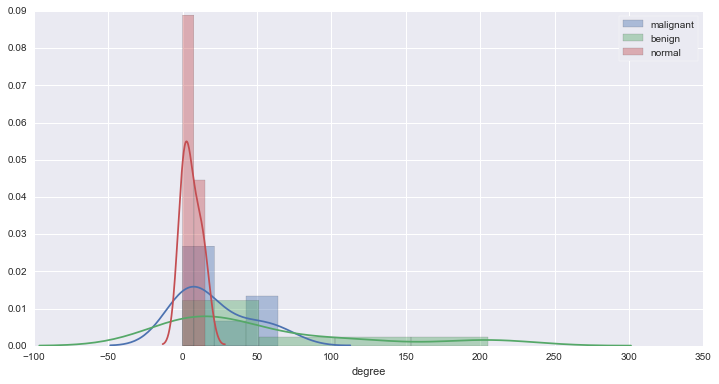

In [422]:
amalignant_degree = nx.degree_histogram(amalignant_MST) 
abening_degree = nx.degree_histogram(abenign_MST) 
anormal_degree = nx.degree_histogram(anormal_MST) 

# e.g:
# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_aveg_Ndegree = pd.Series(amalignant_degree, name="degree")
ax = sns.distplot(pd_amalignant_aveg_Ndegree, label="malignant")
#print(pd_amalignant_aveg_Ndegree)


pd_abenign_aveg_Ndegree = pd.Series(abening_degree, name="degree")
ax = sns.distplot(pd_abenign_aveg_Ndegree, label="benign")

pd_anormal_aveg_Ndegree = pd.Series(anormal_degree, name="degree")
ax = sns.distplot(pd_anormal_aveg_Ndegree, label="normal")
plt.legend()

# density
density(G)[source]

The density for undirected graphs is

$ d = \frac{2m}{n(n-1)},$

and for directed graphs is

$ d = \frac{m}{n(n-1)},$

where n is the number of nodes and m is the number of edges in G.

Notes

The density is 0 for a graph without edges and 1 for a complete graph. The density of multigraphs can be higher than 1.

Self loops are counted in the total number of edges so graphs with self loops can have density higher than 1.

In [423]:
print nx.density(amalignant_MST) 
print nx.density(abenign_MST) 
print nx.density(anormal_MST) 

# eg. info for nodes
print nx.info(amalignant_MST, n=0)
print nx.info(abenign_MST, n=0)
print nx.info(anormal_MST, n=0)

0.0136054421769
0.00469483568075
0.0571428571429
Node 0 has the following properties:
Degree: 4
Neighbors: 126 30 78 6
Node 0 has the following properties:
Degree: 4
Neighbors: 16 4 61 15
Node 0 has the following properties:
Degree: 3
Neighbors: 1 5 13


# Assortativity

source: https://networkx.readthedocs.io/en/stable/reference/algorithms.assortativity.html

degree_assortativity_coefficient(G[, x, y, ...])	Compute degree assortativity of graph.

degree_pearson_correlation_coefficient(G[, ...])	Compute degree assortativity of graph.

The degree is the sum of the edge weights adjacent to the node.

nodes (list or iterable (optional)) – Compute pearson correlation of degrees only for specified nodes. The default is all nodes.

average_neighbor_degree(G[, source, target, ...])	Returns the average degree of the neighborhood of each node.


In [424]:
print(nx.degree_assortativity_coefficient(amalignant_MST) )
print(nx.degree_assortativity_coefficient(abenign_MST) )
print(nx.degree_assortativity_coefficient(anormal_MST) )

-0.255642350067
-0.34926700405
-0.505376344086


In [425]:
print(nx.degree_pearson_correlation_coefficient(amalignant_MST) )
print(nx.degree_pearson_correlation_coefficient(abenign_MST) )
print(nx.degree_pearson_correlation_coefficient(anormal_MST) )


-0.255642350067
-0.34926700405
-0.505376344086


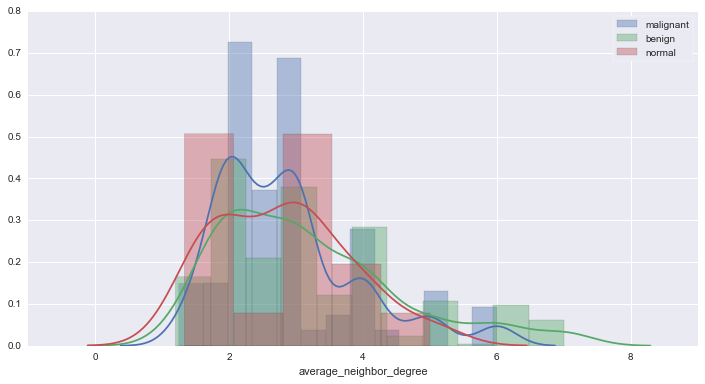

In [426]:
amalignant_aveg_Ndegree = nx.average_neighbor_degree(amalignant_MST) 
abening_aveg_Ndegree = nx.average_neighbor_degree(abenign_MST) 
anormal_aveg_Ndegree = nx.average_neighbor_degree(anormal_MST) 

# e.g:
# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_aveg_Ndegree = pd.Series(amalignant_aveg_Ndegree, name="average_neighbor_degree")
ax = sns.distplot(pd_amalignant_aveg_Ndegree, label="malignant")
#print(pd_amalignant_aveg_Ndegree)


pd_abenign_aveg_Ndegree = pd.Series(abening_aveg_Ndegree, name="average_neighbor_degree")
ax = sns.distplot(pd_abenign_aveg_Ndegree, label="benign")

pd_anormal_aveg_Ndegree = pd.Series(anormal_aveg_Ndegree, name="average_neighbor_degree")
ax = sns.distplot(pd_anormal_aveg_Ndegree, label="normal")
plt.legend()

# Average degree connectivity

source: https://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity

average_degree_connectivity(G[, source, ...])	Compute the average degree connectivity of graph.

k_nearest_neighbors(G[, source, target, ...])	Compute the average degree connectivity of graph.

In [427]:
print(nx.average_degree_connectivity(amalignant_MST) )
print(nx.average_degree_connectivity(abenign_MST) )
print(nx.average_degree_connectivity(anormal_MST) )


{1: 3.28125, 2: 2.6666666666666665, 3: 2.5303030303030303, 4: 2.125, 5: 2.45, 6: 1.9166666666666667}
{1: 3.795121951219512, 2: 2.8468468468468466, 3: 2.611111111111111, 4: 2.301470588235294, 5: 2.381818181818182, 6: 1.7380952380952381, 7: 1.8571428571428572}
{1: 3.2666666666666666, 2: 2.909090909090909, 3: 1.9444444444444444, 4: 1.75, 5: 1.6}


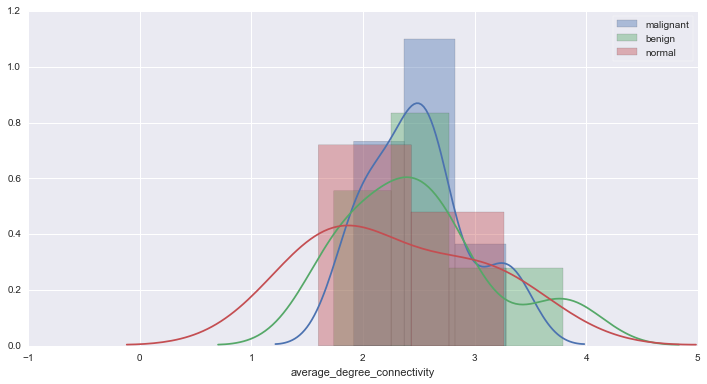

In [428]:
amalignant_aveg_Dconnec = nx.average_degree_connectivity(amalignant_MST) 
abenign_aveg_Dconnec = nx.average_degree_connectivity(abenign_MST) 
anormal_aveg_Dconnec = nx.average_degree_connectivity(anormal_MST) 

# e.g:
# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_aveg_Dconnec = pd.Series(amalignant_aveg_Dconnec, name="average_degree_connectivity")
ax = sns.distplot(pd_amalignant_aveg_Dconnec, label="malignant")

pd_abenign_aveg_Dconnec = pd.Series(abenign_aveg_Dconnec, name="average_degree_connectivity")
ax = sns.distplot(pd_abenign_aveg_Dconnec, label="benign")

pd_anormal_aveg_Dconnec = pd.Series(anormal_aveg_Dconnec, name="average_degree_connectivity")
ax = sns.distplot(pd_anormal_aveg_Dconnec, label="normal")
plt.legend()

# Centrality

source; https://networkx.readthedocs.io/en/stable/reference/algorithms.centrality.html

## Degree
degree_centrality(G)	Compute the degree centrality for nodes.
in_degree_centrality(G)	Compute the in-degree centrality for nodes.
out_degree_centrality(G)	Compute the out-degree centrality for nodes.
## Closeness
closeness_centrality(G[, u, distance, ...])	Compute closeness centrality for nodes.

Notice that higher values of closeness indicate higher centrality.


## Betweenness
betweenness_centrality(G[, k, normalized, ...])	Compute the shortest-path betweenness centrality for nodes.
edge_betweenness_centrality(G[, k, ...])	Compute betweenness centrality for edges.
## Current Flow Closeness
current_flow_closeness_centrality(G[, ...])	Compute current-flow closeness centrality for nodes.
## Current-Flow Betweenness
current_flow_betweenness_centrality(G[, ...])	Compute current-flow betweenness centrality for nodes.
edge_current_flow_betweenness_centrality(G)	Compute current-flow betweenness centrality for edges.
approximate_current_flow_betweenness_centrality(G)	Compute the approximate current-flow betweenness centrality for nodes.
## Eigenvector
eigenvector_centrality(G[, max_iter, tol, ...])	Compute the eigenvector centrality for the graph G.
eigenvector_centrality_numpy(G[, weight])	Compute the eigenvector centrality for the graph G.
katz_centrality(G[, alpha, beta, max_iter, ...])	Compute the Katz centrality for the nodes of the graph G.
katz_centrality_numpy(G[, alpha, beta, ...])	Compute the Katz centrality for the graph G.
## Communicability
communicability(G)	Return communicability between all pairs of nodes in G.
communicability_exp(G)	Return communicability between all pairs of nodes in G.
communicability_centrality(G)	Return communicability centrality for each node in G.
communicability_centrality_exp(G)	Return the communicability centrality for each node of G
communicability_betweenness_centrality(G[, ...])	Return communicability betweenness for all pairs of nodes in G.
estrada_index(G)	Return the Estrada index of a the graph G.
## Load
load_centrality(G[, v, cutoff, normalized, ...])	Compute load centrality for nodes.
edge_load(G[, nodes, cutoff])	Compute edge load.
## Dispersion
dispersion(G[, u, v, normalized, alpha, b, c])	Calculate dispersion between u and v in G.

amalignant_MST degree centrality = 0.013605
abenign_MST degree centrality = 0.004695
anormal_MST degree centrality = 0.057143


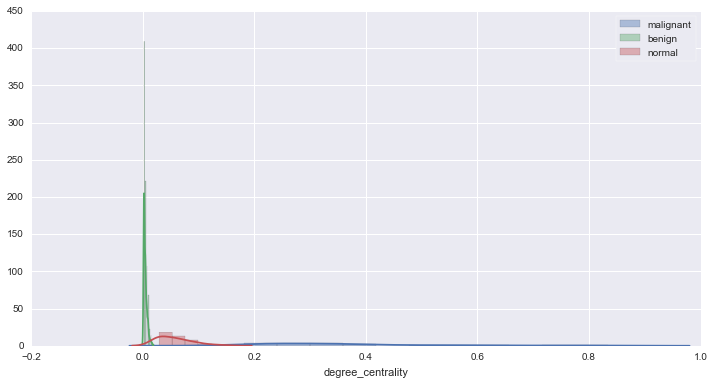

In [429]:
from networkx.algorithms import centrality
amalignant_dcentr = centrality.degree_centrality(amalignant_MST)
abenign_dcentr = centrality.degree_centrality(abenign_MST)
anormal_dcentr = centrality.degree_centrality(anormal_MST)

# e.g:
#print(amalignant_dcentr)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_dcentr = pd.Series(amalignant_dcentr, name="degree_centrality")
ax = sns.distplot(pd_amalignant_Ccoeff, label="malignant")

pd_abenign_dcentr = pd.Series(abenign_dcentr, name="degree_centrality")
ax = sns.distplot(pd_abenign_dcentr, label="benign")

pd_anormal_dcentr = pd.Series(anormal_dcentr, name="degree_centrality")
ax = sns.distplot(pd_anormal_dcentr, label="normal")
plt.legend()

# Compute the average degree centrality for the graph:
print'amalignant_MST degree centrality = %f' % (sum(amalignant_dcentr.values()) / len(amalignant_MST))
print'abenign_MST degree centrality = %f' % (sum(abenign_dcentr.values()) / len(abenign_MST))
print'anormal_MST degree centrality = %f' % (sum(anormal_dcentr.values()) / len(anormal_MST))


# Closeness centrality for nodes.
Closeness centrality [1] of a node u is the reciprocal of the sum of the shortest path 
distances from u to all n-1 other nodes. 

Since the sum of distances depends on the number of nodes in the graph,
closeness is normalized by the sum of minimum possible distances n-1.

If the ‘distance’ keyword is set to an edge attribute key then the shortest-path length will be computed using Dijkstra’s algorithm with that edge attribute as the edge weight.

References

[1]	Linton C. Freeman: Centrality in networks: I. Conceptual clarification. Social Networks 1:215-239, 1979. http://leonidzhukov.ru/hse/2013/socialnetworks/papers/freeman79-centrality.pdf

amalignant_MST closeness_centrality = 0.077652
abenign_MST closeness_centrality = 0.045775
anormal_MST closeness_centrality = 0.153332


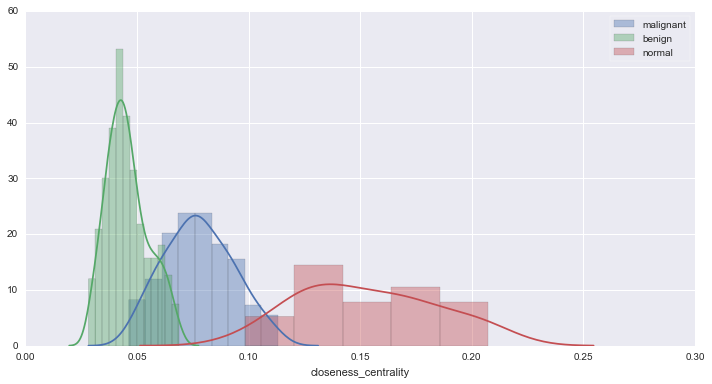

In [430]:
cen_amalignant = centrality.closeness_centrality(amalignant_MST)
cen_abenign = centrality.closeness_centrality(abenign_MST)
cen_anormal = centrality.closeness_centrality(anormal_MST)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_cen_amalignant = pd.Series(cen_amalignant, name="closeness_centrality")
ax = sns.distplot(pd_cen_amalignant, label="malignant")

pd_cen_abenign = pd.Series(cen_abenign, name="closeness_centrality")
ax = sns.distplot(pd_cen_abenign, label="benign")

pd_cen_anormal = pd.Series(cen_anormal, name="closeness_centrality")
ax = sns.distplot(pd_cen_anormal, label="normal")
plt.legend()

# Compute the average closeness_centrality for the graph:
print'amalignant_MST closeness_centrality = %f' % (sum(cen_amalignant.values()) / len(amalignant_MST))
print'abenign_MST closeness_centrality = %f' % (sum(cen_abenign.values()) / len(abenign_MST))
print'anormal_MST closeness_centrality = %f' % (sum(cen_anormal.values()) / len(anormal_MST))


# betweenness_centrality
Compute the shortest-path betweenness centrality for nodes.

Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v.

The algorithm is from Ulrik Brandes [1]. See [4] for the original first published version and [2] for details on algorithms for variations and related metrics.

For approximate betweenness calculations set k=#samples to use k nodes (“pivots”) to estimate the betweenness values. For an estimate of the number of pivots needed see [3].

For weighted graphs the edge weights must be greater than zero. Zero edge weights can produce an infinite number of equal length paths between pairs of nodes.

References

[1]	Ulrik Brandes: A Faster Algorithm for Betweenness Centrality. Journal of Mathematical Sociology 25(2):163-177, 2001. http://www.inf.uni-konstanz.de/algo/publications/b-fabc-01.pdf
[2]	(1, 2) Ulrik Brandes: On Variants of Shortest-Path Betweenness Centrality and their Generic Computation. Social Networks 30(2):136-145, 2008. http://www.inf.uni-konstanz.de/algo/publications/b-vspbc-08.pdf
[3]	Ulrik Brandes and Christian Pich: Centrality Estimation in Large Networks. International Journal of Bifurcation and Chaos 17(7):2303-2318, 2007. http://www.inf.uni-konstanz.de/algo/publications/bp-celn-06.pdf
[4]	Linton C. Freeman: A set of measures of centrality based on betweenness. Sociometry 40: 35–41, 1977 http://moreno.ss.uci.edu/23.pdf



amalignant_MST betweenness centrality = 73.000000
abenign_MST betweenness centrality = 212.000000
anormal_MST betweenness centrality = 17.000000


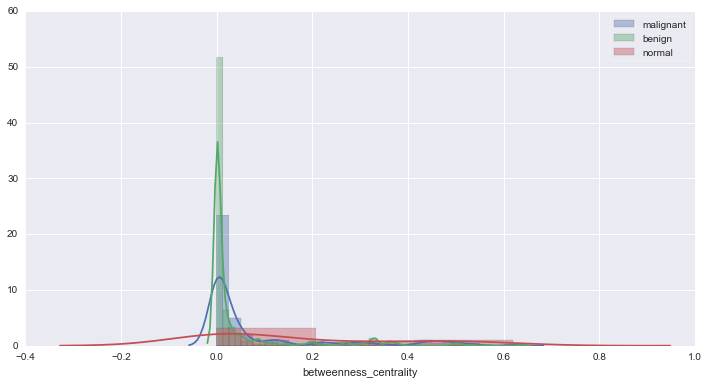

In [431]:
bcen_amalignant = centrality.betweenness_centrality(amalignant_MST)
bcen_abenign = centrality.betweenness_centrality(abenign_MST)
bcen_anormal = centrality.betweenness_centrality(anormal_MST)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_bcen_amalignant = pd.Series(bcen_amalignant, name="betweenness_centrality")
ax = sns.distplot(pd_bcen_amalignant, label="malignant")

pd_bcen_abenign = pd.Series(bcen_abenign, name="betweenness_centrality")
ax = sns.distplot(pd_bcen_abenign, label="benign")

pd_bcen_anormal = pd.Series(bcen_anormal, name="betweenness_centrality")
ax = sns.distplot(pd_bcen_anormal, label="normal")
plt.legend()

# Compute the average betweenness centrality
print'amalignant_MST betweenness centrality = %f' % (sum(bcen_amalignant) / len(amalignant_MST))
print'abenign_MST betweenness centrality = %f' % (sum(bcen_abenign) / len(abenign_MST))
print'anormal_MST betweenness centrality = %f' % (sum(bcen_anormal) / len(anormal_MST))


# edge_betweenness_centrality

Compute betweenness centrality for edges.

Betweenness centrality of an edge e is the sum of the fraction of all-pairs shortest paths 
that pass through e

The algorithm is from Ulrik Brandes [1].

For weighted graphs the edge weights must be greater than zero. Zero edge weights can produce an infinite number of equal length paths between pairs of nodes.

References

[1]	A Faster Algorithm for Betweenness Centrality. Ulrik Brandes, Journal of Mathematical Sociology 25(2):163-177, 2001. http://www.inf.uni-konstanz.de/algo/publications/b-fabc-01.pdf


amalignant_MST edge betweenness centrality = 0.091263
abenign_MST edge betweenness centrality = 0.053427
anormal_MST edge betweenness centrality = 0.193613


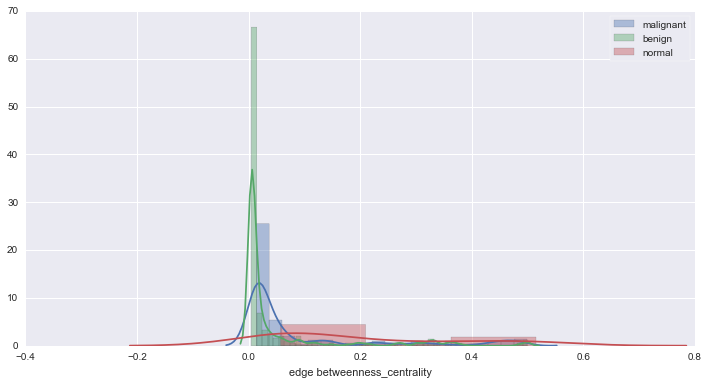

In [432]:
edgebcen_amalignant = centrality.edge_betweenness_centrality(amalignant_MST)
edgebcen_abenign = centrality.edge_betweenness_centrality(abenign_MST)
edgebcen_anormal = centrality.edge_betweenness_centrality(anormal_MST)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_edgebcen_amalignant = pd.Series(edgebcen_amalignant, name="edge betweenness_centrality")
ax = sns.distplot(pd_edgebcen_amalignant, label="malignant")

pd_edgebcen_abenign = pd.Series(edgebcen_abenign, name="edge betweenness_centrality")
ax = sns.distplot(pd_edgebcen_abenign, label="benign")

pd_edgebcen_anormal = pd.Series(edgebcen_anormal, name="edge betweenness_centrality")
ax = sns.distplot(pd_edgebcen_anormal, label="normal")
plt.legend()

# Compute the average edge betweenness centrality
print'amalignant_MST edge betweenness centrality = %f' % (sum(edgebcen_amalignant.values()) / len(amalignant_MST))
print'abenign_MST edge betweenness centrality = %f' % (sum(edgebcen_abenign.values()) / len(abenign_MST))
print'anormal_MST edge betweenness centrality = %f' % (sum(edgebcen_anormal.values()) / len(anormal_MST))


# current_flow_closeness_centrality

current_flow_closeness_centrality

Compute current-flow closeness centrality for nodes.

Current-flow closeness centrality is variant of closeness centrality based on effective resistance
between nodes in a network. This metric is also known as information centrality.

The algorithm is from Brandes [1].

References

[1]	Ulrik Brandes and Daniel Fleischer, Centrality Measures Based on Current Flow. Proc. 22nd Symp. 
Theoretical Aspects of Computer Science (STACS ‘05). LNCS 3404, pp. 533-544. Springer-Verlag, 2005. http://www.inf.uni-konstanz.de/algo/publications/bf-cmbcf-05.pdf

amalignant_MST current_flow_closeness_centrality = 0.000532
abenign_MST current_flow_closeness_centrality = 0.000108
anormal_MST current_flow_closeness_centrality = 0.004510


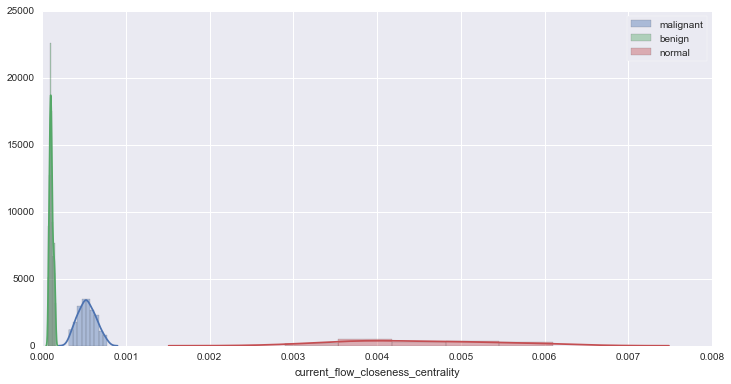

In [433]:
current_flow_closs_centrality_amalignant = centrality.current_flow_closeness_centrality(amalignant_MST, weight=None)
current_flow_closeness_centrality_abenign = centrality.current_flow_closeness_centrality(abenign_MST, weight=None)
current_flow_closeness_centrality_anormal = centrality.current_flow_closeness_centrality(anormal_MST, weight=None)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(current_flow_closeness_centrality_amalignant, name="current_flow_closeness_centrality")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(current_flow_closeness_centrality_abenign, name="current_flow_closeness_centrality")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(current_flow_closeness_centrality_anormal, name="current_flow_closeness_centrality")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average current_flow_closeness_centrality
print'amalignant_MST current_flow_closeness_centrality = %f' % (np.mean(current_flow_closeness_centrality_amalignant.values()))
print'abenign_MST current_flow_closeness_centrality = %f' % (np.mean(current_flow_closeness_centrality_abenign.values()))
print'anormal_MST current_flow_closeness_centrality = %f' % (np.mean(current_flow_closeness_centrality_anormal.values()))

# edge_current_flow_betweenness_centrality
edge_current_flow_betweenness_centrality(G, normalized=True, weight='weight', dtype=<type 'float'>, solver='full')

Compute current-flow betweenness centrality for edges.

Current-flow betweenness centrality uses an electrical current model for information spreading in contrast
to betweenness centrality which uses shortest paths.

Current-flow betweenness centrality is also known as random-walk betweenness centrality [2].

If the edges have a ‘weight’ attribute they will be used as weights in this algorithm. Unspecified weights are set to 1.

References

[1]	Centrality Measures Based on Current Flow. Ulrik Brandes and Daniel Fleischer, Proc. 22nd Symp. Theoretical Aspects of Computer Science (STACS ‘05). LNCS 3404, pp. 533-544. Springer-Verlag, 2005. http://www.inf.uni-konstanz.de/algo/publications/bf-cmbcf-05.pdf

[2]	A measure of betweenness centrality based on random walks, M. E. J. Newman, Social Networks 27, 39-54 (2005).



amalignant_MST edge_current_flow_betweenness_centrality = 0.046578
abenign_MST edge_current_flow_betweenness_centrality = 0.026903
anormal_MST edge_current_flow_betweenness_centrality = 0.105694


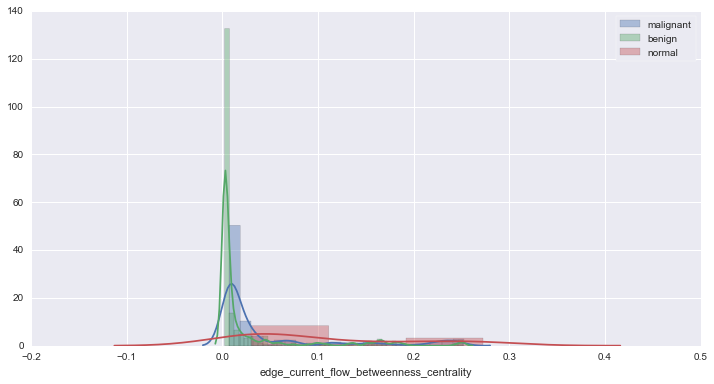

In [434]:
current_flow_edge_betcen_amalignant = centrality.edge_current_flow_betweenness_centrality(amalignant_MST)
current_flow_edge_betcen_abenign = centrality.edge_current_flow_betweenness_centrality(abenign_MST, weight=None)
current_flow_edge_betcen_anormal = centrality.edge_current_flow_betweenness_centrality(anormal_MST, weight=None)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(current_flow_edge_betcen_amalignant, name="edge_current_flow_betweenness_centrality")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(current_flow_edge_betcen_abenign, name="edge_current_flow_betweenness_centrality")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(current_flow_edge_betcen_anormal, name="edge_current_flow_betweenness_centrality")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average edge_current_flow_betweenness_centrality
print'amalignant_MST edge_current_flow_betweenness_centrality = %f' % (np.mean(current_flow_edge_betcen_amalignant.values()))
print'abenign_MST edge_current_flow_betweenness_centrality = %f' % (np.mean(current_flow_edge_betcen_abenign.values()))
print'anormal_MST edge_current_flow_betweenness_centrality = %f' % (np.mean(current_flow_edge_betcen_anormal.values()))

# eigenvector_centrality_numpy

eigenvector_centrality_numpy(G, weight='weight')

Compute the eigenvector centrality for the graph G.

Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. The eigenvector centrality for node i is

$ \mathbf{Ax} = \lambda \mathbf{x} $

where A is the adjacency matrix of the graph G with eigenvalue $\lambda$. By virtue of the Perron–Frobenius theorem, there is a unique and positive solution if $\lambda$ is the largest eigenvalue associated with the eigenvector of the adjacency matrix A ([2]).

The measure was introduced by [1].

This algorithm uses the SciPy sparse eigenvalue solver (ARPACK) to find the largest eigenvalue/eigenvector pair.

### References

[1]	Phillip Bonacich: Power and Centrality: A Family of Measures. American Journal of Sociology 92(5):1170–1182, 1986 http://www.leonidzhukov.net/hse/2014/socialnetworks/papers/Bonacich-Centrality.pdf


['node0: 0.36', 'node1: 0.06', 'node2: 0.00', 'node3: 0.01', 'node4: 0.01', 'node5: 0.68', 'node6: -0.00', 'node7: -0.00', 'node8: -0.00', 'node9: -0.00', 'node10: -0.00', 'node11: 0.00', 'node12: 0.00', 'node13: 0.18', 'node14: 0.00', 'node15: 0.50', 'node16: 0.00', 'node17: 0.34', 'node18: 0.00', 'node19: 0.00', 'node20: 0.00', 'node21: 0.00', 'node22: 0.00', 'node23: -0.00', 'node24: -0.00', 'node25: -0.00', 'node26: -0.00', 'node27: -0.00', 'node28: -0.00', 'node29: -0.00', 'node30: -0.00', 'node31: -0.00', 'node32: 0.00', 'node33: -0.00', 'node34: -0.00']
amalignant_MST eigen_centrality = 0.027979
abenign_MST eigen_centrality = 0.004187
anormal_MST eigen_centrality = 0.061453


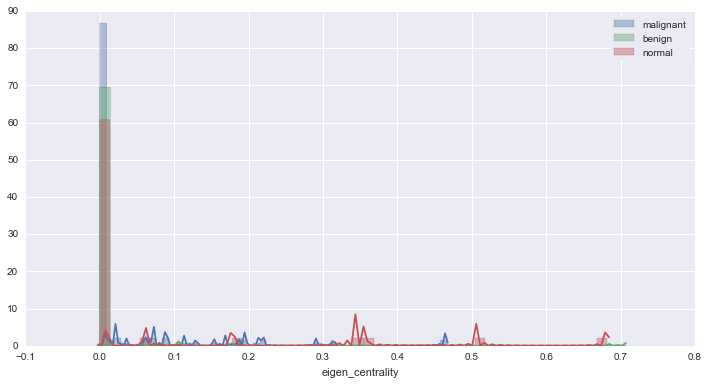

In [435]:
eigen_centrality_amalignant = nx.eigenvector_centrality_numpy(amalignant_MST)
eigen_centrality_abenign = nx.eigenvector_centrality_numpy(abenign_MST)
eigen_centrality_anormal = nx.eigenvector_centrality_numpy(anormal_MST)

print(['node%s: %0.2f'%(node, eigen_centrality_anormal[node]) for node in eigen_centrality_anormal])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(eigen_centrality_amalignant, name="eigen_centrality")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(eigen_centrality_abenign, name="eigen_centrality")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(eigen_centrality_anormal, name="eigen_centrality")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average eigen_centrality
print'amalignant_MST eigen_centrality = %f' % (np.mean(eigen_centrality_amalignant.values()))
print'abenign_MST eigen_centrality = %f' % (np.mean(eigen_centrality_abenign.values()))
print'anormal_MST eigen_centrality = %f' % (np.mean(eigen_centrality_anormal.values()))



# katz_centrality

katz_centrality(G, alpha=0.1, beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')

Compute the Katz centrality for the nodes of the graph G.

Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. The Katz centrality for node i is

$ x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$

where A is the adjacency matrix of the graph G with eigenvalues $\lambda$

The parameter $\beta$ controls the initial centrality and

$ \alpha < \frac{1}{\lambda_{max}}$

Katz centrality computes the relative influence of a node within a network by measuring the number of the immediate neighbors (first degree nodes) and also all other nodes in the network that connect to the node under consideration through these immediate neighbors.


Katz centrality was introduced by [2].

This algorithm it uses the power method to find the eigenvector corresponding to the largest eigenvalue of the adjacency matrix of G. The constant alpha should be strictly less than the inverse of largest eigenvalue of the adjacency matrix for the algorithm to converge. The iteration will stop after max_iter iterations or an error tolerance of number_of_nodes(G)*tol has been reached.

When $\alpha = 1/\lambda_{max}$ and $\beta=0$, Katz centrality is the same as eigenvector centrality.

[2]	Leo Katz: A New Status Index Derived from Sociometric Index. Psychometrika 18(1):39–43, 1953 http://phya.snu.ac.kr/~dkim/PRL87278701.pdf

['node0: 0.09', 'node1: 0.09', 'node2: 0.11', 'node3: 0.10', 'node4: 0.08', 'node5: 0.09', 'node6: 0.10', 'node7: 0.09', 'node8: 0.09', 'node9: 0.09', 'node10: 0.08', 'node11: 0.10', 'node12: 0.11', 'node13: 0.09', 'node14: 0.09', 'node15: 0.08', 'node16: 0.08', 'node17: 0.11', 'node18: 0.10', 'node19: 0.08', 'node20: 0.08', 'node21: 0.09', 'node22: 0.10', 'node23: 0.09', 'node24: 0.09', 'node25: 0.08', 'node26: 0.08', 'node27: 0.10', 'node28: 0.08', 'node29: 0.08', 'node30: 0.08', 'node31: 0.10', 'node32: 0.08', 'node33: 0.09', 'node34: 0.09', 'node35: 0.09', 'node36: 0.08', 'node37: 0.08', 'node38: 0.07', 'node39: 0.09', 'node40: 0.09', 'node41: 0.08', 'node42: 0.08', 'node43: 0.08', 'node44: 0.09', 'node45: 0.08', 'node46: 0.07', 'node47: 0.08', 'node48: 0.09', 'node49: 0.08', 'node50: 0.08', 'node51: 0.09', 'node52: 0.08', 'node53: 0.08', 'node54: 0.09', 'node55: 0.08', 'node56: 0.08', 'node57: 0.08', 'node58: 0.07', 'node59: 0.08', 'node60: 0.08', 'node61: 0.08', 'node62: 0.07', '

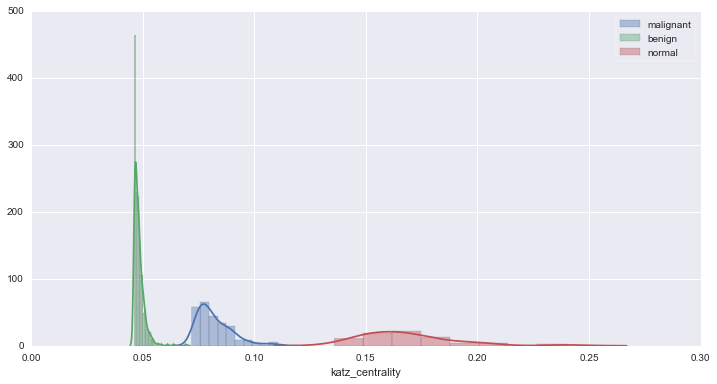

In [436]:
katz_centrality_amalignant = nx.katz_centrality(amalignant_MST)
katz_centrality_abenign = nx.katz_centrality(abenign_MST)
katz_centrality_anormal = nx.katz_centrality(anormal_MST)

print(['node%s: %0.2f'%(node, katz_centrality_amalignant[node]) for node in katz_centrality_amalignant])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(katz_centrality_amalignant, name="katz_centrality")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(katz_centrality_abenign, name="katz_centrality")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(katz_centrality_anormal, name="katz_centrality")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average katz_centrality
print'amalignant_MST katz_centrality = %f' % (np.mean(katz_centrality_amalignant.values()))
print'abenign_MST katz_centrality = %f' % (np.mean(katz_centrality_abenign.values()))
print'anormal_MST katz_centrality = %f' % (np.mean(katz_centrality_anormal.values()))


# communicability_centrality
communicability_centrality(G)

Return communicability centrality for each node in G.

Communicability centrality, also called subgraph centrality, of a node n is the sum of closed walks of all lengths starting and ending at node n.

This version of the algorithm computes eigenvalues and eigenvectors of the adjacency matrix.

Communicability centrality of a node u in G can be found using a spectral decomposition of the adjacency matrix of G [1] [2],

$ SC(u)=\sum_{j=1}^{N}(v_{j}^{u})^2 e^{\lambda_{j}}$,

where $v_j$ is an eigenvector of the adjacency matrix $A$ of $G$ corresponding corresponding to the eigenvalue $\lambda_j$.

[1]	Ernesto Estrada, Juan A. Rodriguez-Velazquez, “Subgraph centrality in complex networks”, Physical Review E 71, 056103 (2005). http://arxiv.org/abs/cond-mat/0504730

[2]	Ernesto Estrada, Naomichi Hatano, “Communicability in complex networks”, Phys. Rev. E 77, 036111 (2008). http://arxiv.org/abs/0707.0756


['node0: 4.12', 'node1: 4.19', 'node2: 4.98', 'node3: 5.17', 'node4: 2.41', 'node5: 3.14', 'node6: 3.95', 'node7: 2.98', 'node8: 3.08', 'node9: 3.14', 'node10: 2.40', 'node11: 5.25', 'node12: 5.38', 'node13: 2.34', 'node14: 3.95', 'node15: 2.34', 'node16: 1.59', 'node17: 4.14', 'node18: 3.21', 'node19: 2.41', 'node20: 2.23', 'node21: 3.15', 'node22: 2.97', 'node23: 2.40', 'node24: 4.20', 'node25: 2.33', 'node26: 1.69', 'node27: 3.82', 'node28: 2.34', 'node29: 1.64', 'node30: 2.63', 'node31: 6.17', 'node32: 1.64', 'node33: 3.09', 'node34: 2.23', 'node35: 2.40', 'node36: 1.64', 'node37: 2.41', 'node38: 1.60', 'node39: 3.25', 'node40: 3.94', 'node41: 1.64', 'node42: 3.31', 'node43: 2.28', 'node44: 4.12', 'node45: 2.34', 'node46: 1.59', 'node47: 2.28', 'node48: 3.25', 'node49: 2.29', 'node50: 1.59', 'node51: 3.08', 'node52: 1.75', 'node53: 1.60', 'node54: 3.20', 'node55: 1.76', 'node56: 1.76', 'node57: 2.57', 'node58: 1.59', 'node59: 1.60', 'node60: 2.41', 'node61: 1.64', 'node62: 1.70', '

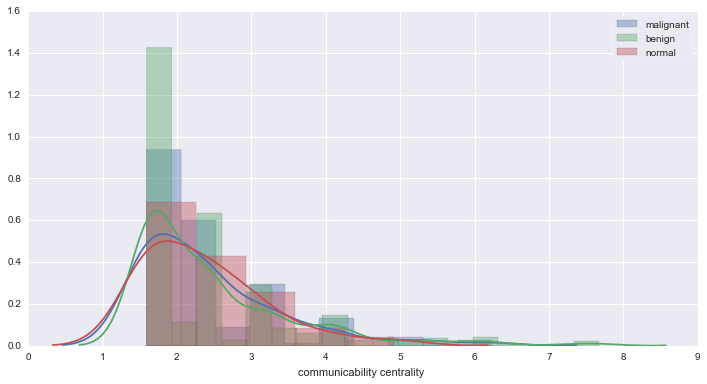

In [437]:
communicabilityCen_amalignant = nx.communicability_centrality(amalignant_MST)
communicabilityCen_abenign = nx.communicability_centrality(abenign_MST)
communicabilityCen_anormal = nx.communicability_centrality(anormal_MST)

print(['node%s: %0.2f'%(node, communicabilityCen_amalignant[node]) for node in communicabilityCen_amalignant])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(communicabilityCen_amalignant, name="communicability centrality ")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(communicabilityCen_abenign, name="communicability centrality ")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(communicabilityCen_anormal, name="communicability centrality ")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average communicability
print'amalignant_MST communicability centrality  = %f' % (np.mean(communicabilityCen_amalignant.values()))
print'abenign_MST communicability centrality  = %f' % (np.mean(communicabilityCen_abenign.values()))
print'anormal_MST communicability centrality  = %f' % (np.mean(communicabilityCen_anormal.values()))


# estrada_index

estrada_index(G)[source]

Return the Estrada index of a the graph G.

Notes

Let $G=(V,E)$ be a simple undirected graph with n nodes and let $\lambda_{1}\leq\lambda_{2}\leq\cdots\lambda_{n}$ be a non-increasing ordering of the eigenvalues of its adjacency matrix A. The Estrada index is

$$ EE(G)=\sum_{j=1}^n e^{\lambda _j} $$.

References

[1]	E. Estrada, Characterization of 3D molecular structure, Chem. Phys. Lett. 319, 713 (2000).


In [438]:
estrada_index_amalignant = nx.estrada_index(amalignant_MST)
estrada_index_abenign = nx.estrada_index(abenign_MST)
estrada_index_anormal = nx.estrada_index(anormal_MST)
print estrada_index_amalignant
print estrada_index_abenign
print estrada_index_anormal


355.992385694
1052.29367193
82.2935778175


# load_centrality

##### load_centrality(G, v=None, cutoff=None, normalized=True, weight=None)

The load centrality of a node is the fraction of all shortest paths that pass through that node.

Parameters:	
G (graph) – A networkx graph
normalized (bool, optional) – If True the betweenness values are normalized by b=b/(n-1)(n-2) where n is the number of nodes in G.

weight (None or string, optional) – If None, edge weights are ignored. Otherwise holds the name of the edge attribute used as weight.

cutoff (bool, optional) – If specified, only consider paths of length <= cutoff.

Returns:	
nodes – Dictionary of nodes with centrality as the value.


Notes
Load centrality is slightly different than betweenness. It was originally introduced by [2]. For this load algorithm see [1].

References

[1]	Mark E. J. Newman: Scientific collaboration networks. II. Shortest paths, weighted networks, and centrality. Physical Review E 64, 016132, 2001. http://journals.aps.org/pre/abstract/10.1103/PhysRevE.64.016132

[2]	Kwang-Il Goh, Byungnam Kahng and Doochul Kim Universal behavior of Load Distribution in Scale-Free Networks. Physical Review Letters 87(27):1–4, 2001. http://phya.snu.ac.kr/~dkim/PRL87278701.pdf
Next  Previous


['node0: 0.21', 'node1: 0.22', 'node2: 0.09', 'node3: 0.11', 'node4: 0.01', 'node5: 0.05', 'node6: 0.04', 'node7: 0.03', 'node8: 0.04', 'node9: 0.04', 'node10: 0.01', 'node11: 0.62', 'node12: 0.23', 'node13: 0.03', 'node14: 0.49', 'node15: 0.01', 'node16: 0.00', 'node17: 0.13', 'node18: 0.04', 'node19: 0.01', 'node20: 0.01', 'node21: 0.03', 'node22: 0.03', 'node23: 0.05', 'node24: 0.14', 'node25: 0.03', 'node26: 0.00', 'node27: 0.04', 'node28: 0.07', 'node29: 0.00', 'node30: 0.22', 'node31: 0.53', 'node32: 0.00', 'node33: 0.44', 'node34: 0.01', 'node35: 0.04', 'node36: 0.00', 'node37: 0.01', 'node38: 0.00', 'node39: 0.50', 'node40: 0.05', 'node41: 0.00', 'node42: 0.44', 'node43: 0.01', 'node44: 0.41', 'node45: 0.01', 'node46: 0.00', 'node47: 0.01', 'node48: 0.36', 'node49: 0.01', 'node50: 0.00', 'node51: 0.33', 'node52: 0.00', 'node53: 0.00', 'node54: 0.12', 'node55: 0.00', 'node56: 0.00', 'node57: 0.48', 'node58: 0.00', 'node59: 0.00', 'node60: 0.01', 'node61: 0.00', 'node62: 0.00', '

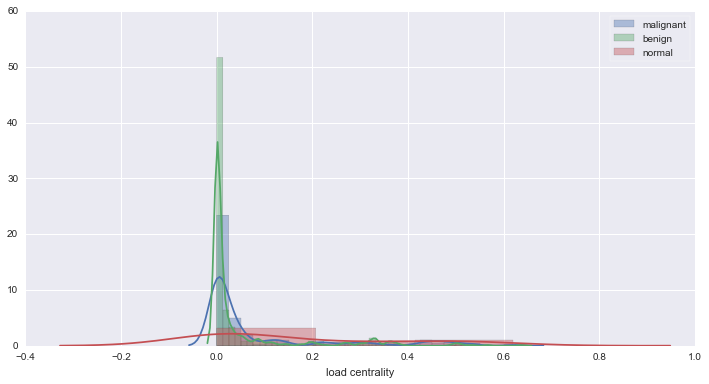

In [439]:
load_centrality_amalignant = nx.load_centrality(amalignant_MST)
load_centrality_abenign = nx.load_centrality(abenign_MST)
load_centrality_anormal = nx.load_centrality(anormal_MST)

print(['node%s: %0.2f'%(node, load_centrality_amalignant[node]) for node in load_centrality_amalignant])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(load_centrality_amalignant, name="load centrality")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(load_centrality_abenign, name="load centrality")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(load_centrality_anormal, name="load centrality")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average communicability
print'amalignant_MST load_centrality = %f' % (np.mean(load_centrality_amalignant.values()))
print'abenign_MST load_centrality = %f' % (np.mean(load_centrality_abenign.values()))
print'anormal_MST load_centrality = %f' % (np.mean(load_centrality_anormal.values()))



# Clustering

https://networkx.readthedocs.io/en/stable/reference/algorithms.clustering.html

Algorithms to characterize the number of triangles in a graph.

 triangles(G[, nodes])	Compute the number of triangles.

 transitivity(G)	Compute graph transitivity, the fraction of all possible triangles present in G.

 clustering(G[, nodes, weight])	Compute the clustering coefficient for nodes.
 
 References

[1]	Generalizations of the clustering coefficient to weighted complex networks by J. Saramäki, M. Kivelä, J.-P. Onnela, K. Kaski, and J. Kertész, Physical Review E, 75 027105 (2007). http://jponnela.com/web_documents/a9.pdf

 average_clustering(G[, nodes, weight, ...])	Compute the average clustering coefficient for the graph G.

 square_clustering(G[, nodes])	Compute the squares clustering coefficient for nodes.



['node 0: 3.00', 'node 1: 3.00', 'node 2: 4.00', 'node 3: 5.00', 'node 4: 4.00', 'node 5: 5.00', 'node 6: 6.00', 'node 7: 6.00', 'node 8: 4.00', 'node 9: 6.00', 'node 10: 5.00', 'node 11: 5.00', 'node 12: 7.00', 'node 13: 4.00', 'node 14: 5.00', 'node 15: 6.00', 'node 16: 5.00', 'node 17: 6.00', 'node 18: 10.00', 'node 19: 7.00', 'node 20: 5.00', 'node 21: 5.00', 'node 22: 5.00', 'node 23: 6.00', 'node 24: 8.00', 'node 25: 5.00', 'node 26: 7.00', 'node 27: 8.00', 'node 28: 7.00', 'node 29: 6.00', 'node 30: 3.00', 'node 31: 9.00', 'node 32: 6.00', 'node 33: 5.00', 'node 34: 3.00', 'node 35: 5.00', 'node 36: 6.00', 'node 37: 7.00', 'node 38: 4.00', 'node 39: 10.00', 'node 40: 7.00', 'node 41: 6.00', 'node 42: 8.00', 'node 43: 6.00', 'node 44: 7.00', 'node 45: 6.00', 'node 46: 4.00', 'node 47: 6.00', 'node 48: 6.00', 'node 49: 6.00', 'node 50: 7.00', 'node 51: 5.00', 'node 52: 4.00', 'node 53: 6.00', 'node 54: 6.00', 'node 55: 5.00', 'node 56: 7.00', 'node 57: 7.00', 'node 58: 5.00', 'nod

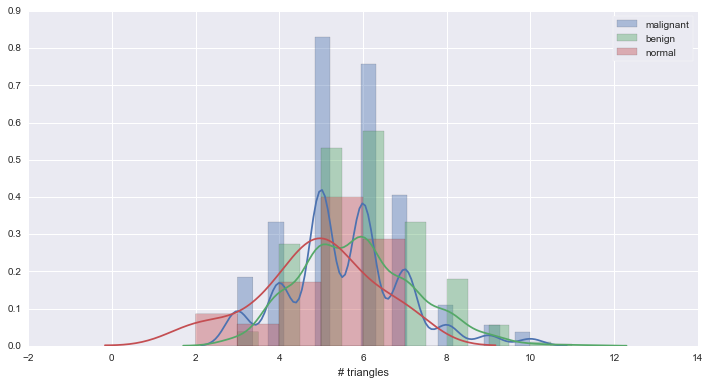

In [440]:
triangles_amalignant = nx.triangles(amalignant_DEL)
triangles_abenign = nx.triangles(abenign_DEL)
triangles_anormal = nx.triangles(anormal_DEL)

print(['node %s: %0.2f'%(node, triangles_amalignant[node]) for node in triangles_amalignant])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(triangles_amalignant, name="# triangles")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(triangles_abenign, name="# triangles")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(triangles_anormal, name="# triangles")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average No triangles
print'amalignant_DEL triangles = %f' % (np.mean(triangles_amalignant.values()))
print'abenign_DEL triangles = %f' % (np.mean(triangles_abenign.values()))
print'anormal_DEL triangles = %f' % (np.mean(triangles_anormal.values()))

# Compute the transitivity
print'amalignant_DEL transitivity = %f' % nx.transitivity(amalignant_DEL)
print'abenign_DEL transitivity = %f' % nx.transitivity(abenign_DEL)
print'anormal_DEL transitivity = %f' % nx.transitivity(anormal_DEL)


['node 0: 0.50', 'node 1: 0.50', 'node 2: 0.40', 'node 3: 0.50', 'node 4: 0.67', 'node 5: 0.50', 'node 6: 0.40', 'node 7: 0.40', 'node 8: 0.67', 'node 9: 0.40', 'node 10: 0.50', 'node 11: 0.50', 'node 12: 0.33', 'node 13: 0.67', 'node 14: 0.50', 'node 15: 0.40', 'node 16: 0.33', 'node 17: 0.40', 'node 18: 0.22', 'node 19: 0.33', 'node 20: 0.50', 'node 21: 0.50', 'node 22: 0.50', 'node 23: 0.40', 'node 24: 0.22', 'node 25: 0.50', 'node 26: 0.33', 'node 27: 0.29', 'node 28: 0.33', 'node 29: 0.40', 'node 30: 0.50', 'node 31: 0.25', 'node 32: 0.40', 'node 33: 0.50', 'node 34: 0.50', 'node 35: 0.50', 'node 36: 0.40', 'node 37: 0.33', 'node 38: 0.67', 'node 39: 0.22', 'node 40: 0.33', 'node 41: 0.40', 'node 42: 0.29', 'node 43: 0.40', 'node 44: 0.33', 'node 45: 0.40', 'node 46: 0.67', 'node 47: 0.40', 'node 48: 0.40', 'node 49: 0.40', 'node 50: 0.33', 'node 51: 0.50', 'node 52: 0.67', 'node 53: 0.40', 'node 54: 0.29', 'node 55: 0.50', 'node 56: 0.33', 'node 57: 0.33', 'node 58: 0.50', 'node 

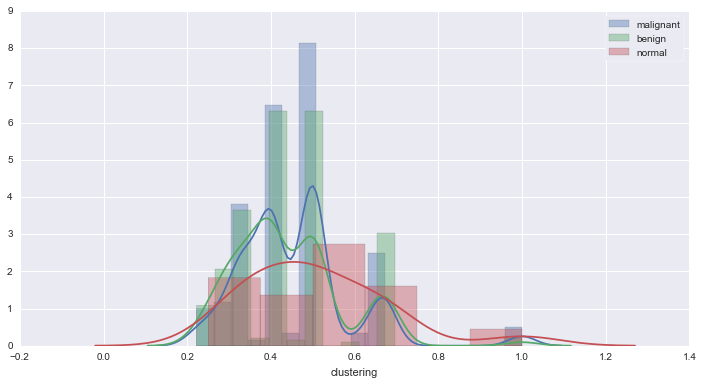

In [441]:
clustering_amalignant = nx.clustering(amalignant_DEL)
clustering_abenign = nx.clustering(abenign_DEL)
clustering_anormal = nx.clustering(anormal_DEL)

print(['node %s: %0.2f'%(node, clustering_amalignant[node]) for node in clustering_amalignant])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(clustering_amalignant, name="clustering")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(clustering_abenign, name="clustering")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(clustering_anormal, name="clustering")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average clustering
print'amalignant_DEL average clustering = %f' % nx.average_clustering(amalignant_DEL)
print'abenign_DEL average clustering = %f' % nx.average_clustering(abenign_DEL)
print'anormal_DEL average clustering = %f' % nx.average_clustering(anormal_DEL)


# Link Analysis 

##### pagerank_numpy(G, alpha=0.85, personalization=None, weight='weight', dangling=None)
https://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank_numpy.html
PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

Parameters:	
G (graph) – A NetworkX graph. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge.
alpha (float, optional) – Damping parameter for PageRank, default=0.85.
...
Returns:	
pagerank – Dictionary of nodes with PageRank as value

The eigenvector calculation uses NumPy’s interface to the LAPACK eigenvalue solvers. This will be the fastest and most accurate for small graphs.

This implementation works with Multi(Di)Graphs. For multigraphs the weight between two nodes is set to be the sum of all edge weights between those nodes.

References
[1]	A. Langville and C. Meyer, “A survey of eigenvector methods of web information retrieval.” http://citeseer.ist.psu.edu/713792.html

[2]	Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry, The PageRank citation ranking: Bringing order to the Web. 1999 http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf

['node 0: 0.0112', 'node 1: 0.0112', 'node 2: 0.0164', 'node 3: 0.0141', 'node 4: 0.0057', 'node 5: 0.0091', 'node 6: 0.0144', 'node 7: 0.0115', 'node 8: 0.0107', 'node 9: 0.0107', 'node 10: 0.0071', 'node 11: 0.0140', 'node 12: 0.0142', 'node 13: 0.0075', 'node 14: 0.0113', 'node 15: 0.0070', 'node 16: 0.0051', 'node 17: 0.0127', 'node 18: 0.0100', 'node 19: 0.0067', 'node 20: 0.0081', 'node 21: 0.0120', 'node 22: 0.0114', 'node 23: 0.0069', 'node 24: 0.0110', 'node 25: 0.0065', 'node 26: 0.0043', 'node 27: 0.0146', 'node 28: 0.0062', 'node 29: 0.0042', 'node 30: 0.0056', 'node 31: 0.0149', 'node 32: 0.0043', 'node 33: 0.0100', 'node 34: 0.0083', 'node 35: 0.0067', 'node 36: 0.0042', 'node 37: 0.0068', 'node 38: 0.0039', 'node 39: 0.0088', 'node 40: 0.0133', 'node 41: 0.0052', 'node 42: 0.0074', 'node 43: 0.0070', 'node 44: 0.0107', 'node 45: 0.0072', 'node 46: 0.0042', 'node 47: 0.0076', 'node 48: 0.0088', 'node 49: 0.0075', 'node 50: 0.0045', 'node 51: 0.0095', 'node 52: 0.0037', 'n

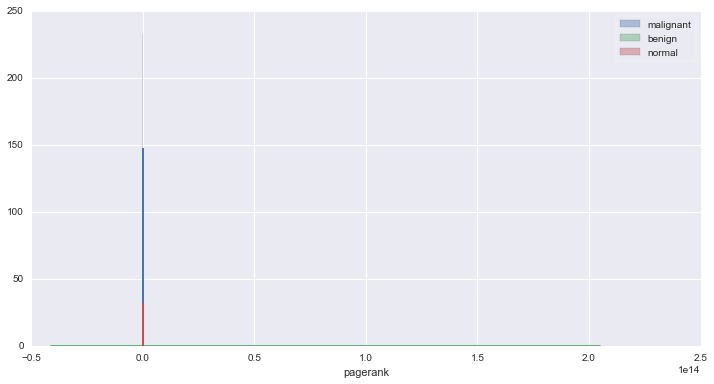

In [442]:
pagerank_amalignant = nx.pagerank_numpy(amalignant_MST)
pagerank_abenign = nx.pagerank_numpy(abenign_MST)
pagerank_anormal = nx.pagerank_numpy(anormal_MST)

print(['node %s: %0.4f'%(node, pagerank_amalignant[node]) for node in pagerank_amalignant])

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(pagerank_amalignant.values(), name="pagerank")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(pagerank_abenign.values(), name="pagerank")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(pagerank_anormal.values(), name="pagerank")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the average pagerank
print'amalignant_MST average pagerank = %f' % np.mean(pagerank_amalignant.values())
print'abenign_MST average pagerank = %f' % np.mean(pagerank_abenign.values())
print'anormal_MST average pagerank = %f' % np.mean(pagerank_anormal.values())

# Operators
https://networkx.readthedocs.io/en/stable/reference/algorithms.operators.html

#### Unary operations on graphs

complement(G[, name])	Return the graph complement of G.

reverse(G[, copy])	Return the reverse directed graph of G.

#### Operations on graphs including union, intersection, difference.
compose(G, H[, name])	Return a new graph of G composed with H.

union(G, H[, rename, name])	Return the union of graphs G and H.

disjoint_union(G, H)	Return the disjoint union of graphs G and H.

intersection(G, H)	Return a new graph that contains only the edges that exist in both G and H.

difference(G, H)	Return a new graph that contains the edges that exist in G but not in H.

symmetric_difference(G, H)	Return new graph with edges that exist in either G or H but not both.

#### Operations on many graphs.
compose_all(graphs[, name])	Return the composition of all graphs.

union_all(graphs[, rename, name])	Return the union of all graphs.

disjoint_union_all(graphs)	Return the disjoint union of all graphs.

intersection_all(graphs)	Return a new graph that contains only the edges that exist in all graphs.


#### Graph products.
cartesian_product(G, H)	Return the Cartesian product of G and H.

lexicographic_product(G, H)	Return the lexicographic product of G and H.

strong_product(G, H)	Return the strong product of G and H.

tensor_product(G, H)	Return the tensor product of G and H.

power(G, k)	Returns the specified power of a graph.

# rich_club_coefficient
rich_club_coefficient(G, normalized=True, Q=100)

The rich-club coefficient is the ratio, for every degree k, of the number of actual to the number of potential edges for nodes with degree greater than k:

$\phi(k) = \frac{2 Ek}{Nk(Nk-1)}$

where $Nk$ is the number of nodes with degree larger than k, and $Ek$ be the number of edges among those nodes.

Return type:	
dictionary

Notes

The rich club definition and algorithm are found in [1]. This algorithm ignores any edge weights and is not defined for directed graphs or graphs with parallel edges or self loops.

Estimates for appropriate values of Q are found in [2].

References

[1]	(1, 2) Julian J. McAuley, Luciano da Fontoura Costa, and Tibério S. Caetano, “The rich-club phenomenon across complex network hierarchies”, Applied Physics Letters Vol 91 Issue 8, August 2007. http://arxiv.org/abs/physics/0701290

[2]	R. Milo, N. Kashtan, S. Itzkovitz, M. E. J. Newman, U. Alon, “Uniform generation of random graphs with arbitrary degree sequences”, 2006. http://arxiv.org/abs/cond-mat/0312028

{0: 1.0, 1: 0.9111111111111111, 2: 0.8928571428571429, 3: 0.7142857142857142, 4: 1.0, 5: 1.0}
amalignant_MST rich_club_coefficient = 0.919709
{0: 1.0, 1: 0.894308943089431, 2: 0.7053571428571428, 3: 0.4545454545454546, 4: 0.4, 5: 0.5, 6: 1.0}
abenign_MST rich_club_coefficient = 0.707745
{0: 1.0, 1: 1.0, 2: 0.42857142857142855, 3: 1.0}
anormal_MST rich_club_coefficient = 0.857143


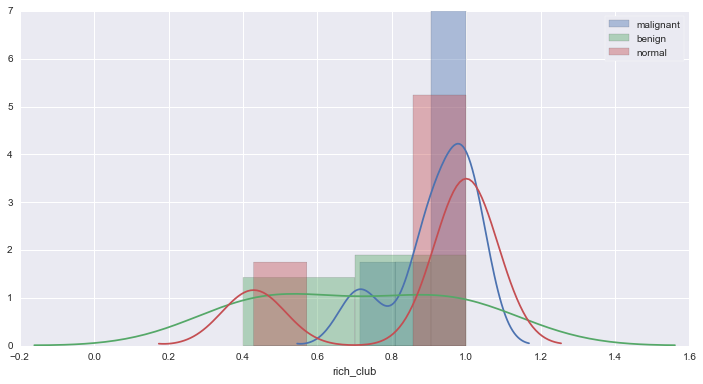

In [443]:
rich_club_amalignant = nx.rich_club_coefficient(amalignant_MST)
rich_club_abenign = nx.rich_club_coefficient(abenign_MST)
rich_club_anormal = nx.rich_club_coefficient(anormal_MST)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(rich_club_amalignant.values(), name="rich_club")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(rich_club_abenign.values(), name="rich_club")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(rich_club_anormal.values(), name="rich_club")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the rich_club_coefficient
print rich_club_amalignant
print'amalignant_MST rich_club_coefficient = %f' % np.mean(rich_club_amalignant.values())
print rich_club_abenign
print'abenign_MST rich_club_coefficient = %f' % np.mean(rich_club_abenign.values())
print rich_club_anormal
print'anormal_MST rich_club_coefficient = %f' % np.mean(rich_club_anormal.values())

# closeness_vitality
closeness_vitality(G, weight=None)[source]

Closeness vitality of a node is the change in the sum of distances between all node pairs when excluding that node.

Return type:	
dictionary

References

[1]	Ulrik Brandes, Sec. 3.6.2 in Network Analysis: Methodological Foundations, Springer, 2005. http://books.google.com/books?id=TTNhSm7HYrIC

amalignant_MST rich_club_coefficient = 36204.108844
abenign_MST rich_club_coefficient = 282951.821596
anormal_MST rich_club_coefficient = 2285.714286


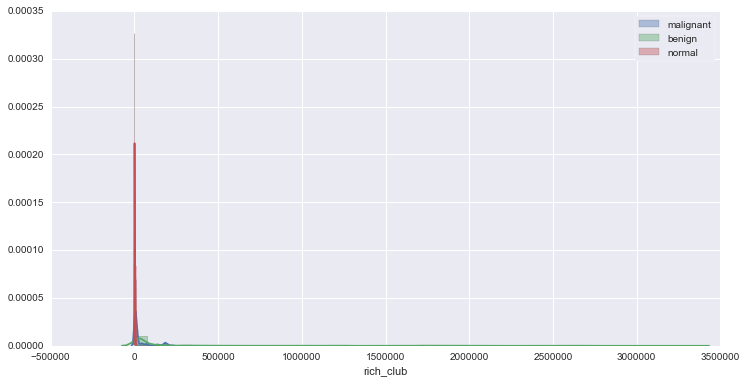

In [444]:
closeness_vit_amalignant = nx.closeness_vitality(amalignant_MST)
closeness_vit_abenign = nx.closeness_vitality(abenign_MST)
closeness_vit_anormal = nx.closeness_vitality(anormal_MST)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant = pd.Series(closeness_vit_amalignant.values(), name="rich_club")
ax = sns.distplot(pd_amalignant, label="malignant")

pd_abenign = pd.Series(closeness_vit_abenign.values(), name="rich_club")
ax = sns.distplot(pd_abenign, label="benign")

pd_anormal = pd.Series(closeness_vit_anormal.values(), name="rich_club")
ax = sns.distplot(pd_anormal, label="normal")
plt.legend()

# Compute the rich_club_coefficient
print'amalignant_MST rich_club_coefficient = %f' % np.mean(closeness_vit_amalignant.values())
print'abenign_MST rich_club_coefficient = %f' % np.mean(closeness_vit_abenign.values())
print'anormal_MST rich_club_coefficient = %f' % np.mean(closeness_vit_anormal.values())

# Bipartite

This module provides functions and operations for bipartite graphs. Bipartite graphs B = (U, V, E) have two node sets U,V and edges in E that only connect nodes from opposite sets. It is common in the literature to use an spatial analogy referring to the two node sets as top and bottom nodes.

In [445]:
print(nx.is_bipartite(amalignant_MST))
print(nx.is_bipartite(abenign_MST))
print(nx.is_bipartite(anormal_MST))

left, right = nx.bipartite.sets(amalignant_MST)
print(left)
print(right)

True
True
True
set([0, 4, 5, 7, 136, 9, 10, 11, 13, 14, 16, 17, 18, 19, 21, 141, 24, 27, 28, 31, 133, 36, 38, 40, 41, 42, 43, 46, 48, 50, 52, 54, 55, 58, 60, 146, 64, 65, 139, 68, 70, 76, 145, 79, 80, 81, 85, 86, 87, 88, 135, 95, 96, 144, 99, 102, 142, 105, 106, 108, 109, 110, 111, 112, 114, 116, 117, 118, 119, 137, 123, 124, 125, 127])
set([128, 1, 2, 3, 132, 6, 129, 8, 138, 12, 130, 15, 131, 20, 22, 23, 25, 26, 29, 30, 32, 33, 34, 35, 37, 39, 44, 45, 47, 49, 51, 53, 134, 56, 57, 59, 61, 62, 63, 66, 67, 69, 71, 72, 73, 74, 75, 143, 77, 78, 82, 83, 84, 89, 90, 91, 92, 93, 94, 97, 98, 100, 101, 103, 104, 107, 113, 140, 115, 120, 121, 122, 126])


# Clustering
https://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.bipartite.cluster.clustering.html#networkx.algorithms.bipartite.cluster.clustering

clustering(G[, nodes, mode])	Compute a bipartite clustering coefficient for nodes.
    
    Returns
    clustering – A dictionary keyed by node with the clustering coefficient value.

average_clustering(G[, nodes, mode])	Compute the average bipartite clustering coefficient.

latapy_clustering(G[, nodes, mode])	Compute a bipartite clustering coefficient for nodes.

robins_alexander_clustering(G)	Compute the bipartite clustering of G.

{0: 0.21851851851851853, 1: 0.20595238095238094, 2: 0.18333333333333335, 3: 0.18928571428571428, 4: 0.3208333333333333, 5: 0.2375, 6: 0.20000000000000004, 7: 0.125, 8: 0.2333333333333333, 9: 0.26666666666666666, 10: 0.3958333333333333, 11: 0.16160714285714287, 12: 0.17761904761904762, 13: 0.2976190476190476, 14: 0.16203703703703703, 15: 0.38888888888888884, 16: 0.3333333333333333, 17: 0.19027777777777777, 18: 0.2452380952380952, 19: 0.2791666666666667, 20: 0.25, 21: 0.25, 22: 0.25, 23: 0.3125, 24: 0.2, 25: 0.39999999999999997, 26: 0.8333333333333334, 27: 0.2, 28: 0.2333333333333333, 29: 0.75, 30: 0.3479166666666667, 31: 0.12301587301587302, 32: 0.375, 33: 0.20555555555555557, 34: 0.16666666666666666, 35: 0.3333333333333333, 36: 0.75, 37: 0.3125, 38: 0.2, 39: 0.26944444444444443, 40: 0.20555555555555557, 41: 0.41666666666666663, 42: 0.2714285714285714, 43: 0.375, 44: 0.19166666666666665, 45: 0.4166666666666667, 46: 0.25, 47: 0.35, 48: 0.27499999999999997, 49: 0.225, 50: 0.33333333333333

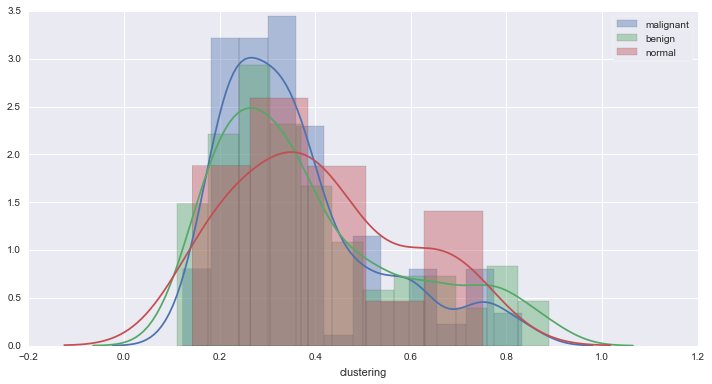

In [446]:
from networkx.algorithms import bipartite
amalignant_Ccoeff = bipartite.clustering(amalignant_MST)
abenign_Ccoeff = bipartite.clustering(abenign_MST)
anormal_Ccoeff = bipartite.clustering(anormal_MST)

# e.g:
print(amalignant_Ccoeff)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_amalignant_Ccoeff = pd.Series(amalignant_Ccoeff, name="clustering")
ax = sns.distplot(pd_amalignant_Ccoeff, label="malignant")

pd_abenign_Ccoeff = pd.Series(abenign_Ccoeff, name="clustering")
ax = sns.distplot(pd_abenign_Ccoeff, label="benign")

pd_anormal_Ccoeff = pd.Series(anormal_Ccoeff, name="clustering")
ax = sns.distplot(pd_anormal_Ccoeff, label="normal")
plt.legend()


In [447]:
# https://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.bipartite.cluster.average_clustering.html
print('amalignant = %f' %bipartite.average_clustering(amalignant_MST))
Lamalignant,Ramalignant=bipartite.sets(amalignant_MST)
print('Left = %f' % bipartite.average_clustering(amalignant_MST,Lamalignant))
print('Right = %f \n' % bipartite.average_clustering(amalignant_MST,Ramalignant))

print('abenign = %f' %bipartite.average_clustering(abenign_MST))
Labenign,Rabenign=bipartite.sets(abenign_MST)
print('Left = %f' % bipartite.average_clustering(abenign_MST,Labenign))
print('Right = %f \n' % bipartite.average_clustering(abenign_MST,Rabenign))

print('anormal = %f' %bipartite.average_clustering(anormal_MST))
Lanormal,Ranormal=bipartite.sets(anormal_MST)
print('Left = %f' % bipartite.average_clustering(anormal_MST,Lanormal))
print('Right = %f \n' % bipartite.average_clustering(anormal_MST,Ranormal))

amalignant = 0.362513
Left = 0.367219
Right = 0.357743 

abenign = 0.390547
Left = 0.431209
Right = 0.342379 

anormal = 0.406812
Left = 0.358783
Right = 0.442833 



# Redundancy
https://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.bipartite.redundancy.node_redundancy.html
    
Node redundancy for bipartite graphs.

The redundancy coefficient of a node v is the fraction of pairs of neighbors of v that are both linked to other nodes. In a one-mode projection these nodes would be linked together even if v were not there.

node_redundancy(G[, nodes])	Computes the node redundancy coefficients for the nodes in the bipartite graph G.


[0.8333333333333334, 0.8333333333333334, 0.7, 1.0, 1.0, 0.9, 0.7333333333333333, 0.8, 1.0, 0.8, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.8, 0.6, 0.8, 0.4444444444444444, 0.6666666666666666, 1.0, 1.0, 1.0, 0.8, 0.4166666666666667, 1.0, 0.6666666666666666, 0.5714285714285714, 0.6666666666666666, 0.8, 0.8333333333333334, 0.4444444444444444, 0.8, 1.0, 0.8333333333333334, 1.0, 0.8, 0.6666666666666666, 1.0, 0.4444444444444444, 0.6666666666666666, 0.7333333333333333, 0.5714285714285714, 0.8, 0.6666666666666666, 0.8, 1.0, 0.8, 0.8, 0.8, 0.6666666666666666, 1.0, 0.8333333333333334, 0.8, 0.5238095238095238, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 0.9, 0.7333333333333333, 1.0, 0.8333333333333334, 0.5714285714285714, 1.0, 0.8, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.8, 0.9, 0.8, 1.0, 0.8333333333333334, 1.0, 0.8, 0.9333333333333333, 0.7333333333333333, 0.9, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.73

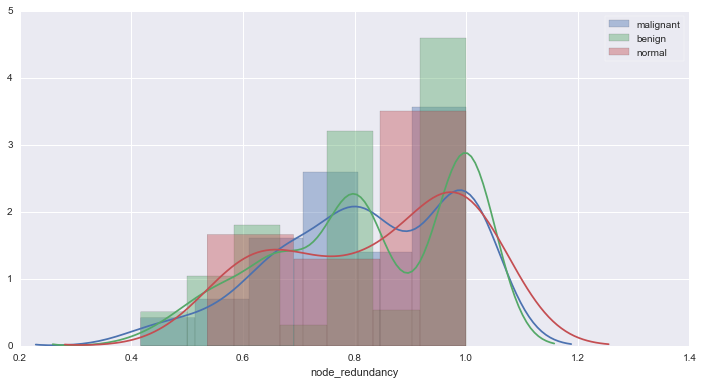

In [448]:
rc_amalignant = bipartite.node_redundancy(amalignant_DEL)
print rc_amalignant.values()

rc_abenign = bipartite.node_redundancy(abenign_DEL)
rc_anormal = bipartite.node_redundancy(anormal_DEL)

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_rc_amalignant = pd.Series(rc_amalignant, name="node_redundancy")
ax = sns.distplot(pd_rc_amalignant, label="malignant")

pd_rc_abenign = pd.Series(rc_abenign, name="node_redundancy")
ax = sns.distplot(pd_rc_abenign, label="benign")

pd_rc_anormal = pd.Series(rc_anormal, name="node_redundancy")
ax = sns.distplot(pd_rc_anormal, label="normal")
plt.legend()

# Compute the average redundancy for the graph:
print'amalignant_DEL mean redundancy = %f' % (sum(rc_amalignant.values()) / len(amalignant_DEL))
print'abenign_DEL mean redundancy = %f' % (sum(rc_abenign.values()) / len(abenign_DEL))
print'anormal_DEL mean redundancy = %f' % (sum(rc_anormal.values()) / len(anormal_DEL))



# Closeness Centrality

Compute the closeness centrality for nodes in a bipartite network.

The closeness of a node is the distance to all other nodes in the graph or in the case that the graph is not connected to all other nodes in the connected component containing that node.

Higher values of closeness indicate higher centrality.

As in the unipartite case, setting normalized=True causes the values to normalized further to n-1 / size(G)-1 where n is the number of nodes in the connected part of graph containing the node. If the graph is not completely connected, this algorithm computes the closeness centrality for each connected part separately.

closeness_centrality(G, nodes[, normalized])	Compute the closeness centrality for nodes in a bipartite network.



[0.17600964436407474, 0.1672394043528064, 0.10703812316715543, 0.14614614614614616, 0.13638486688463336, 0.15507169410515134, 0.16240266963292546, 0.16986620127981383, 0.16609783845278725, 0.16, 0.10170672239637757, 0.22618125484120838, 0.20857142857142857, 0.17432835820895523, 0.2154981549815498, 0.19492656875834447, 0.1598248494800219, 0.19147540983606556, 0.18973359324236516, 0.18924173687621518, 0.16061606160616063, 0.13651238896680692, 0.15036045314109167, 0.17569193742478942, 0.15623327982878546, 0.1442687747035573, 0.15682062298603652, 0.1700640652300524, 0.20263705759888967, 0.15665236051502146, 0.18863049095607234, 0.2029186935371786, 0.14822335025380712, 0.18693982074263765, 0.09694555112881806, 0.17548076923076922, 0.13991375179683757, 0.20362622036262204, 0.18492716909436352, 0.21376281112737922, 0.19427811044577512, 0.1534419337887546, 0.18035824583075974, 0.15360336664913204, 0.17319098457888493, 0.17739975698663427, 0.16303740926856505, 0.1483739837398374, 0.165439093484

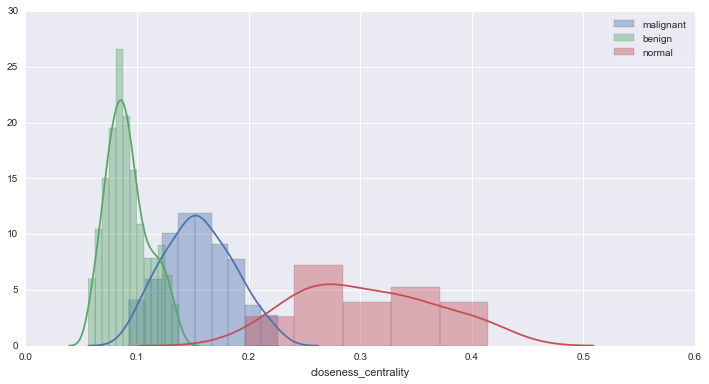

In [449]:
cen_amalignant = bipartite.closeness_centrality(amalignant_MST, amalignant_MST.nodes())
print cen_amalignant.values()

cen_abenign = bipartite.closeness_centrality(abenign_MST, abenign_MST.nodes())
cen_anormal = bipartite.closeness_centrality(anormal_MST, anormal_MST.nodes())

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_cen_amalignant = pd.Series(cen_amalignant, name="closeness_centrality")
ax = sns.distplot(pd_cen_amalignant, label="malignant")

pd_cen_abenign = pd.Series(cen_abenign, name="closeness_centrality")
ax = sns.distplot(pd_cen_abenign, label="benign")

pd_cen_anormal = pd.Series(cen_anormal, name="closeness_centrality")
ax = sns.distplot(pd_cen_anormal, label="normal")
plt.legend()

# Compute the average closeness_centrality for the graph:
print'amalignant_MST closeness_centrality = %f' % (sum(cen_amalignant.values()) / len(amalignant_MST))
print'abenign_MST closeness_centrality = %f' % (sum(cen_abenign.values()) / len(abenign_MST))
print'anormal_MST closeness_centrality = %f' % (sum(cen_anormal.values()) / len(anormal_MST))


# degree_centrality
Compute the degree centrality for nodes in a bipartite network.

The degree centrality for a node v is the fraction of nodes connected to it. 

For unipartite networks, the degree centrality values are normalized by dividing by the maximum possible degree (which is n-1 where n is the number of nodes in G).

In the bipartite case, the maximum possible degree of a node in a bipartite node set is the number of nodes in the opposite node set

degree_centrality(G, nodes)	Compute the degree centrality for nodes in a bipartite network.



[0.0547945205479452, 0.05405405405405406, 0.06756756756756757, 0.06756756756756757, 0.0273972602739726, 0.0410958904109589, 0.05405405405405406, 0.0410958904109589, 0.04054054054054054, 0.0410958904109589, 0.0273972602739726, 0.0684931506849315, 0.06756756756756757, 0.0273972602739726, 0.0547945205479452, 0.02702702702702703, 0.0136986301369863, 0.0547945205479452, 0.0410958904109589, 0.0273972602739726, 0.02702702702702703, 0.0410958904109589, 0.04054054054054054, 0.02702702702702703, 0.0547945205479452, 0.02702702702702703, 0.013513513513513514, 0.0547945205479452, 0.0273972602739726, 0.013513513513513514, 0.02702702702702703, 0.0821917808219178, 0.013513513513513514, 0.04054054054054054, 0.02702702702702703, 0.02702702702702703, 0.0136986301369863, 0.02702702702702703, 0.0136986301369863, 0.04054054054054054, 0.0547945205479452, 0.0136986301369863, 0.0410958904109589, 0.0273972602739726, 0.05405405405405406, 0.02702702702702703, 0.0136986301369863, 0.02702702702702703, 0.04109589041

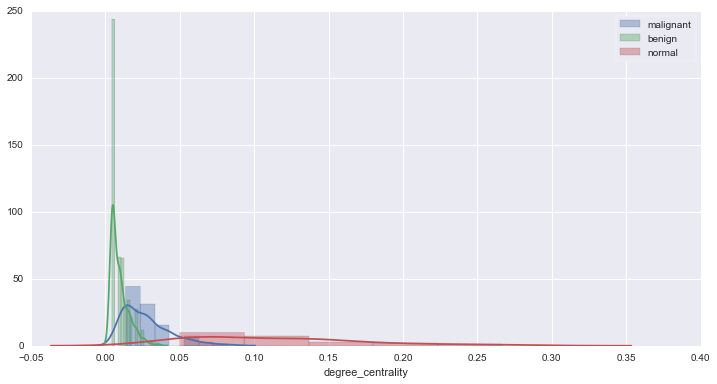

In [450]:
dcen_Lamalignant = bipartite.degree_centrality(amalignant_MST, Lamalignant)
dcen_Ramalignant = bipartite.degree_centrality(amalignant_MST, Ramalignant)

combined_dcen_amalignant = [dcen_Lamalignant.values(),dcen_Ramalignant.values()][0]
print combined_dcen_amalignant

dcen_Labenign = bipartite.degree_centrality(abenign_MST, Labenign)
dcen_Rabenign = bipartite.degree_centrality(abenign_MST, Rabenign)
combined_dcen_abenign = [dcen_Labenign.values(),dcen_Rabenign.values()][0]

dcen_Lanormal = bipartite.degree_centrality(anormal_MST, Lanormal)
dcen_Ranormal = bipartite.degree_centrality(anormal_MST, Ranormal)
combined_dcen_anormal = [dcen_Lanormal.values(),dcen_Ranormal.values()][0]

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_dcen_amalignant = pd.Series(combined_dcen_amalignant, name="degree_centrality")
ax = sns.distplot(pd_dcen_amalignant, label="malignant")

pd_dcen_abenign = pd.Series(combined_dcen_abenign, name="degree_centrality")
ax = sns.distplot(pd_dcen_abenign, label="benign")

pd_dcen_anormal = pd.Series(combined_dcen_anormal, name="degree_centrality")
ax = sns.distplot(pd_dcen_anormal, label="normal")
plt.legend()

# Compute the average degree centrality for the graph:
print'amalignant_MST degree centrality = %f' % (sum(combined_dcen_amalignant) / len(amalignant_MST))
print'abenign_MST degree centrality = %f' % (sum(combined_dcen_abenign) / len(abenign_MST))
print'anormal_MST degree centrality = %f' % (sum(combined_dcen_anormal) / len(anormal_MST))




# betweenness_centrality

Compute betweenness centrality for nodes in a bipartite network.

Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v.

Values of betweenness are normalized by the maximum possible value which for bipartite graphs is limited by the relative size of the two node sets [1].

betweenness_centrality(G, nodes)	Compute betweenness centrality for nodes in a bipartite network.


[0.21565829528158295, 0.2264814990963569, 0.09416912394178636, 0.10720060877009417, 0.013793759512937594, 0.05431887366818874, 0.04109198135641587, 0.027492389649923895, 0.04099686102920194, 0.04100076103500761, 0.013793759512937594, 0.6292808219178082, 0.22781318367735184, 0.0273972602739726, 0.4947678843226788, 0.013792447446019214, 0.0, 0.13213470319634704, 0.04100076103500761, 0.013793759512937594, 0.013792447446019214, 0.027492389649923895, 0.027489774564824505, 0.05402834585750975, 0.1430745814307458, 0.027394654237610578, 0.0, 0.0410958904109589, 0.0670662100456621, 0.0, 0.21915723390088462, 0.5344368340943684, 0.0, 0.4418339199086845, 0.013792447446019214, 0.04080662037477409, 0.0, 0.013792447446019214, 0.0, 0.5072767050318653, 0.054509132420091325, 0.0, 0.4421613394216134, 0.013793759512937594, 0.41348806239893465, 0.013792447446019214, 0.0, 0.013792447446019214, 0.3606354642313546, 0.013792447446019214, 0.0, 0.333777228193665, 0.0, 0.0, 0.11805555555555555, 0.0, 0.0, 0.482545

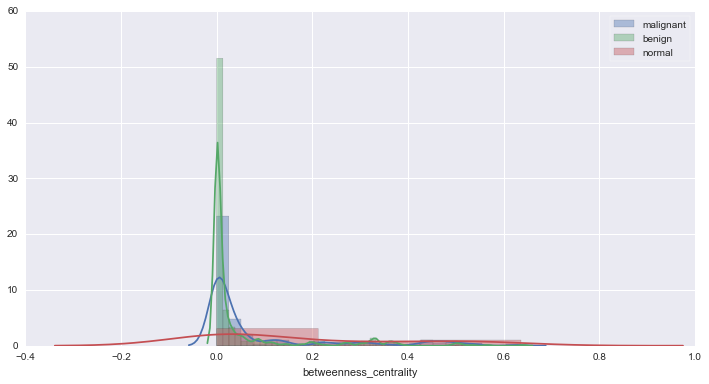

In [451]:
bcen_Lamalignant = bipartite.betweenness_centrality(amalignant_MST, Lamalignant)
bcen_Ramalignant = bipartite.betweenness_centrality(amalignant_MST, Ramalignant)

combined_bcen_amalignant = [bcen_Lamalignant.values(),bcen_Ramalignant.values()][0]
print combined_bcen_amalignant

bcen_Labenign = bipartite.betweenness_centrality(abenign_MST, Labenign)
bcen_Rabenign = bipartite.betweenness_centrality(abenign_MST, Rabenign)
combined_bcen_abenign = [bcen_Labenign.values(),bcen_Rabenign.values()][0]

bcen_Lanormal = bipartite.betweenness_centrality(anormal_MST, Lanormal)
bcen_Ranormal = bipartite.betweenness_centrality(anormal_MST, Ranormal)
combined_bcen_anormal = [bcen_Lanormal.values(),bcen_Ranormal.values()][0]

# plot
sns.set(rc={"figure.figsize": (12, 6)}); 
sns.set_style("darkgrid", {"legend.frameon": True})
pd_bcen_amalignant = pd.Series(combined_bcen_amalignant, name="betweenness_centrality")
ax = sns.distplot(pd_bcen_amalignant, label="malignant")

pd_bcen_abenign = pd.Series(combined_bcen_abenign, name="betweenness_centrality")
ax = sns.distplot(pd_bcen_abenign, label="benign")

pd_bcen_anormal = pd.Series(combined_bcen_anormal, name="betweenness_centrality")
ax = sns.distplot(pd_bcen_anormal, label="normal")
plt.legend()

# Compute the average degree centrality for the graph:
print'amalignant_MST betweenness centrality = %f' % (sum(combined_bcen_amalignant) / len(amalignant_MST))
print'abenign_MST betweenness centrality = %f' % (sum(combined_bcen_abenign) / len(abenign_MST))
print'anormal_MST betweenness centrality = %f' % (sum(combined_bcen_anormal) / len(anormal_MST))
